# Pixel classification using Scikit image
Pixel classification is a technique for assigning pixels to multiple classes. If there are two classes (object and background), we are talking about binarization. In this example we use a [random forest classifier](https://en.wikipedia.org/wiki/Random_forest) for pixel classification.

See also
* [Scikit-image random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [Classification of land cover by Chris Holden](https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html)


In [2]:
# !pip install scikit-image
# !pip install -U scikit-learn
# !pip install "napari[all]"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 1.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 3.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 4.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 3.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 3.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 4.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.9/222.9 kB 2.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 4.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 3.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from skimage.io import imsave, imread
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


# Define input path

In [3]:
# path to the folder containing the images of a certain channel

filepath = '/media/eschmidt/WD_Elements/EPFL-data/Lucas/'

fn_orange = 'orange_20230920_AirGel_WTmSc_dwspFmN_mix_LAM02J-L_CIP_5.5hpi_23.5h.nd...el_WTmSc_dwspFmN_mix_LAM02J-L_CIP_5.5hpi_23.5h.nd2 (series 08) - C=1.tif'
fn_green = 'green_20230920_AirGel_WTmSc_dwspFmN_mix_LAM02J-L_CIP_5.5hpi_23.5h.nd...el_WTmSc_dwspFmN_mix_LAM02J-L_CIP_5.5hpi_23.5h.nd2 (series 08) - C=0.tif'


orange = filepath + fn_orange
green = filepath + fn_green

# if orange endswith .nd2 then import pims_nd2
if orange.endswith('.nd2'):
    !pip install pims_nd2
    import pims_nd2 as pims

else:
    !pip install pims
    import pims


In [4]:
import napari
%gui qt

def Draw_and_Save(img,output_dir,output_fn):
    viewer = napari.Viewer()
    viewer.add_image(img)
    labels = viewer.add_labels(np.zeros(img.shape,dtype='uint8'))

    print("before block")
    viewer.show(block=True)

    print("after block")
    # get the drawings first
    manual_annotations = labels.data

    # save the drawings
    manual_labels_filename = output_dir + '/' + output_fn
    imsave(manual_labels_filename, manual_annotations, check_contrast=False)
    viewer.close()


In [15]:
import napari
%gui qt

viewer = napari.Viewer()
viewer.add_image(orange_zstack)
viewer.show(block=True)
print("somethintg")



somethintg


# Prepare GT and save it together with the image

In [5]:
output_dir = '../data_3D/'


In [6]:
# create output directory
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

if not os.path.exists(output_dir + "orange"):
    os.makedirs(output_dir + "orange/GT")

if not os.path.exists(output_dir + "green"):
    os.makedirs(output_dir + "green/GT")

if not os.path.exists(output_dir + "orange/RAW"):
    os.makedirs(output_dir + "orange/RAW")

if not os.path.exists(output_dir + "green/RAW"):
    os.makedirs(output_dir + "green/RAW")


In [13]:
orange_seq = pims.open(orange)
green_seq = pims.open(green)
Z_slices = 19
xdim = 1200
ydim = 1200

timestep = 0
counter = 0
for t, (img_o, img_g) in enumerate(zip(orange_seq,green_seq)):
    

    # iterate through all z slices and stack them together
    if np.mod(t,Z_slices) == 0:
        # prepare empty array with the same dtype as the first image
        counter = 0
        orange_zstack = np.zeros((Z_slices,xdim,ydim))
        green_zstack = np.zeros((Z_slices,xdim,ydim))

    orange_zstack[counter,:,:] = img_o
    green_zstack[counter,:,:] = img_g

    if np.mod(t,Z_slices) == Z_slices-1:
        print("Timestep: ", timestep)

        # now there is a 3D image stack of 19 slices
        print(orange_zstack.shape)
        print(green_zstack.shape)

        # start napari, save GT and RAW images
        # keep the basename of fn

        print(fn_orange)
        Draw_and_Save(orange_zstack, output_dir + "orange/GT/", 'T_'+str(timestep).zfill(3)+ '_' + fn_orange + '.tif')
        imsave(output_dir + "orange/RAW/" + 'T_'+str(timestep).zfill(3)+  '_' + fn_orange , orange_zstack,check_contrast=False)

        Draw_and_Save(green_zstack, output_dir + "green/GT/", 'T_'+str(timestep).zfill(3)+ '_' + fn_green )
        imsave(output_dir + "green/RAW/" + 'T_'+str(timestep).zfill(3) + '_' +  fn_green, green_zstack,check_contrast=False)


        timestep += 1

    counter += 1



Timestep:  0
(19, 1200, 1200)
(19, 1200, 1200)
orange_20230920_AirGel_WTmSc_dwspFmN_mix_LAM02J-L_CIP_5.5hpi_23.5h.nd...el_WTmSc_dwspFmN_mix_LAM02J-L_CIP_5.5hpi_23.5h.nd2 (series 08) - C=1


before block


after block


before block


IndexError: list index out of range

IndexError: list index out of range

after block
Timestep:  1
(19, 1200, 1200)
(19, 1200, 1200)
orange_20230920_AirGel_WTmSc_dwspFmN_mix_LAM02J-L_CIP_5.5hpi_23.5h.nd...el_WTmSc_dwspFmN_mix_LAM02J-L_CIP_5.5hpi_23.5h


KeyboardInterrupt: 

# Now work with the GT to train the model

In [7]:


# Now go through all existing GT files that contain non-zero pixels
green_gt_fn = os.listdir(output_dir + "green/GT")
orange_gt_fn = os.listdir(output_dir + "orange/GT")

green_gt_fn

['green_20230920_AirGel_WTmSc_dwspFmN_mix_LAM02J-L_CIP_5.5hpi_23.5h.nd...el_WTmSc_dwspFmN_mix_LAM02J-L_CIP_5.5hpi_23.5h.nd2 (series 08) - C=0.tif_T_001.tif',
 'green_20230920_AirGel_WTmSc_dwspFmN_mix_LAM02J-L_CIP_5.5hpi_23.5h.nd...el_WTmSc_dwspFmN_mix_LAM02J-L_CIP_5.5hpi_23.5h.nd2 (series 08) - C=0.tif_T_000.tif']

## Generating a feature stack
Pixel classifiers such as the random forest classifier takes multiple images as input. We typically call these images a feature stack because for every pixel exist now multiple values (features). In the following example we create a feature stack containing three features:
* The original pixel value
* The pixel value after a Gaussian blur
* The pixel value of the Gaussian blurred image processed through a Sobel operator.

Thus, we denoise the image and detect edges. All three images serve the pixel classifier to differentiate positive an negative pixels.

In [8]:
from skimage import filters

def generate_feature_stack(image):
    # determine features
    blurred = filters.gaussian(image, sigma=2)
    edges = filters.sobel(blurred)

    # collect features in a stack
    # The ravel() function turns a nD image into a 1-D image.
    # We need to use it because scikit-learn expects values in a 1-D format here.
    feature_stack = [
        image.ravel(),
        blurred.ravel(),
        edges.ravel()
    ]

    # return stack as numpy-array
    return np.asarray(feature_stack)


## Formating data
We now need to format the input data so that it fits to what scikit learn expects. Scikit-learn asks for an array of shape (n, m) as input data and (n) annotations. n corresponds to number of pixels and m to number of features. In our case m = 3.

In [9]:
def format_data(feature_stack, annotation):
    # reformat the data to match what scikit-learn expects
    # transpose the feature stack
    X = feature_stack.T
    # make the annotation 1-dimensional
    y = annotation.ravel()

    # remove all pixels from the feature and annotations which have not been annotated
    mask = y > 0
    X = X[mask]
    y = y[mask]

    return X, y

In [40]:

# in case you have not much memory as I do, you should run only one channel at a time

channels = ['orange', 'green']
filename_array = [orange_gt_fn, green_gt_fn]


# make this to a for loop later
channel = channels[0]
filenames = filename_array[0]


X_stack = []
y_stack = []

for fn in filenames:
    print(fn)

    img = imread(output_dir + channel + "/RAW/" + fn)
    annotation = imread(output_dir + channel + "/GT/" + fn)
    feature_stack = generate_feature_stack(img)
    X, y = format_data(feature_stack, annotation)
       
    X_stack.append(X)
    y_stack.append(y)

    # delete variables to save memory
    del X, y, img, feature_stack
    
X_stack = np.concatenate(X_stack)
y_stack = np.concatenate(y_stack)

<tifffile.TiffPages @8> corrupted tag list of page 2 @218880272 raised TiffFileError('suspicious number of tags 34283')


orange_20230920_AirGel_WTmSc_dwspFmN_mix_LAM02J-L_CIP_5.5hpi_23.5h.nd...el_WTmSc_dwspFmN_mix_LAM02J-L_CIP_5.5hpi_23.5h.nd2 (series 08) - C=1.tif_T_000.tif


<tifffile.TiffPages @8> invalid page offset 1943076864


orange_20230920_AirGel_WTmSc_dwspFmN_mix_LAM02J-L_CIP_5.5hpi_23.5h.nd...el_WTmSc_dwspFmN_mix_LAM02J-L_CIP_5.5hpi_23.5h.nd2 (series 08) - C=1.tif_T_001.tif


/home/eschmidt/miniconda3/envs/competition_env/lib/python3.12/site-packages/skimage/filters/edges.py:181: RuntimeWarning: overflow encountered in multiply
  ax_output *= ax_output


In [41]:
X_stack.shape

(93305, 3)

In [43]:
mask = X_stack != np.inf
mask.shape

(93305, 3)

In [44]:
X_stack.shape

(93305, 3)

In [49]:
# remove infinite values
mask = X_stack != np.inf
mask = np.sum(mask,axis=1) > 2
mask.shape


(93305,)

In [50]:
X_stack = X_stack[mask,:]
y_stack = y_stack[mask]


# Training begins

In [53]:
filename = 'model_for_3D_data.pkl'

In [52]:
# train classifier if not trained yet
classifier = RandomForestClassifier()




param_grid = {
    'n_estimators': [50,100],  # Vary the number of trees
    'max_depth': [2, 3],       # Vary the maximum depth of trees
}


grid_search = GridSearchCV(classifier, param_grid, cv=5)
grid_search.fit(X_stack, y_stack)  # X and y are your training data and labels, respectively



GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 3], 'n_estimators': [50, 100]})

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 3.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 5.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 kB 7.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 5.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 3.9 MB/s eta 0:00:00


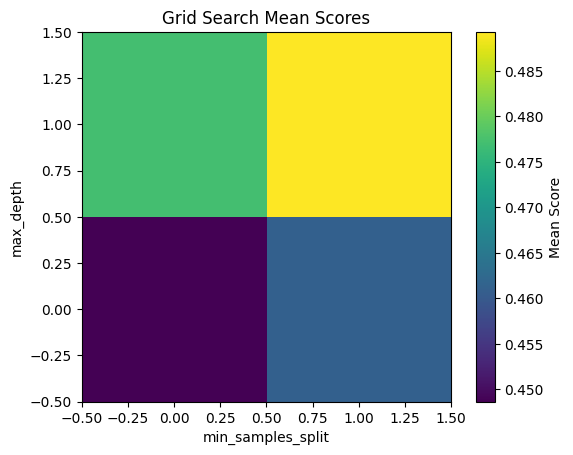

In [56]:
results = grid_search.cv_results_

# Extract the mean scores and reshape them into a grid
scores = np.array(results['mean_test_score']).reshape(len(param_grid['n_estimators']),
                                                      len(param_grid['max_depth']))


import matplotlib.pyplot as plt
# Create a heatmap of the mean scores
plt.imshow(scores, cmap='viridis', origin='lower')
plt.colorbar(label='Mean Score')
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.title('Grid Search Mean Scores')
plt.show()

In [57]:
best_classifier = grid_search.best_estimator_


In [61]:
# save classifier 
import pickle
model_directory = "../models/RFC_3D/"

import os
if not os.path.exists("../models"):
    os.makedirs("../models")

if not os.path.exists(model_directory):
    os.makedirs(model_directory)


pickle.dump(best_classifier, open(model_directory+filename, 'wb'))

# Now go to the other notebook for prediction. 